# **Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from imutils import paths
import matplotlib.pyplot as plt
import shutil
import PIL
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Dataset Loading**

In [2]:
DATASET_PATH="D:/Bachelor/ISIC 2019 Dataset"
TRAINING_PATH=DATASET_PATH+'/Training/Test'
VALIDATION_PATH=DATASET_PATH+'/Validation'
TEST_PATH=DATASET_PATH+'/Test'
GROUND_TRUTH_PATH=DATASET_PATH+'/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(GROUND_TRUTH_PATH, index_col='image')

BENIGN_TRAINING_PATH = TRAINING_PATH+'/0'
MEL_TRAINING_PATH = TRAINING_PATH+'/1'

BENIGN_TRAINING_PATHS = sorted(paths.list_images(BENIGN_TRAINING_PATH))
print("Working with {0} non-melanoma images".format(len(BENIGN_TRAINING_PATHS)))

MEL_TRAINING_PATHS = sorted(paths.list_images(MEL_TRAINING_PATH))
print("Working with {0} melanoma images".format(len(MEL_TRAINING_PATHS)))

Working with 10851 non-melanoma images
Working with 7234 melanoma images


## **Dataset Testing**

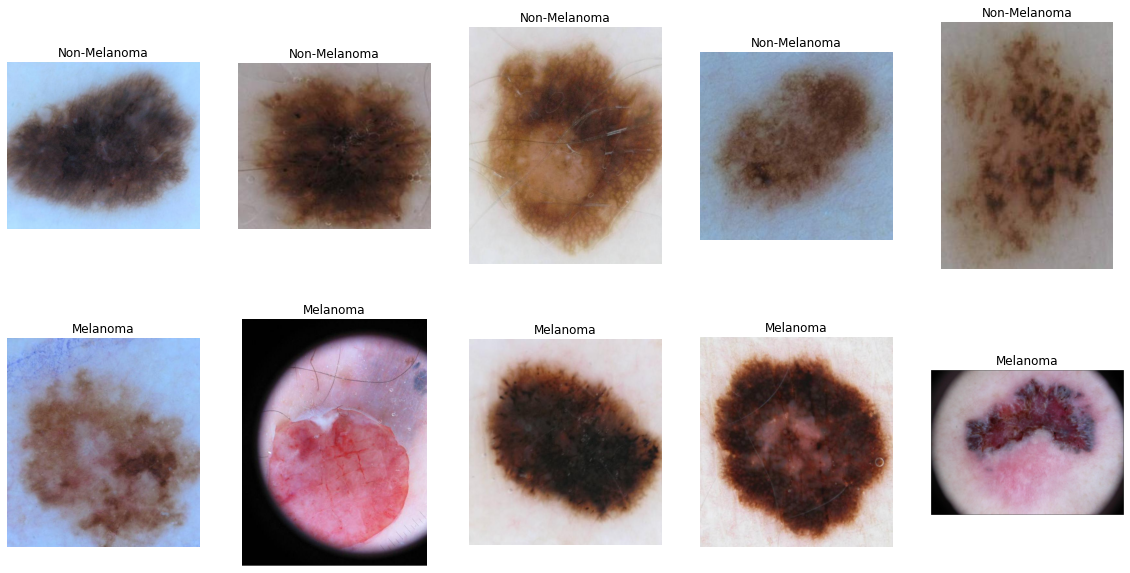

In [11]:
plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(PIL.Image.open(BENIGN_TRAINING_PATHS[i]))
    plt.title("Non-Melanoma")
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 1+5)
    plt.imshow(PIL.Image.open(MEL_TRAINING_PATHS[i]))
    plt.title("Melanoma")
    plt.axis("off")

# **ResNet152V2**

In [3]:
size=224
base = tf.keras.applications.ResNet152V2(input_shape=[size,size,3], weights='imagenet', include_top=False)

base.trainable = False
# Create new model on top
inputs = keras.Input(shape=(size, size, 3))
x=inputs
x=base(x,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 58,335,746
Trainable params: 4,098
Non-trainable params: 58,331,648
_________________________________________________________________


In [4]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
batch=128
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_set = validation_datagen.flow_from_directory(VALIDATION_PATH,(size,size), batch_size=batch,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(TRAINING_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')

Found 2533 images belonging to 2 classes.
Found 18085 images belonging to 2 classes.


In [6]:
callbacks = [ModelCheckpoint(filepath=DATASET_PATH+'/model/ResNet152V2', 
                               verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001, restore_best_weights=True)]

start = datetime.now()

model_history=model.fit(
  train_set,
  validation_data=validation_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50


c:\program files\python39\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


142/142 [==============================] - 237s 2s/step - loss: 0.5914 - binary_accuracy: 0.7020 - val_loss: 0.5232 - val_binary_accuracy: 0.7560

Epoch 00001: val_loss improved from inf to 0.52323, saving model to D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2\assets
Epoch 2/50
142/142 [==============================] - 232s 2s/step - loss: 0.5249 - binary_accuracy: 0.7450 - val_loss: 0.4317 - val_binary_accuracy: 0.8298

Epoch 00002: val_loss improved from 0.52323 to 0.43166, saving model to D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2\assets
Epoch 3/50
142/142 [==============================] - 225s 2s/step - loss: 0.5106 - binary_accuracy: 0.7559 - val_loss: 0.4248 - val_binary_accuracy: 0.8255

Epoch 00003: val_loss improved from 0.43166 to 0.42478, saving model to D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2\assets
Epoch 4/50
142/142 [==============================] - 232s 2s/step - loss: 0.4948 - binary_accuracy: 0.7669 - val_loss: 0.4315 - val_binary_accuracy: 0.8247

Epoch 00004: val_loss did not improve from 0.42478
Epoch 5/50
142/142 [==============================] - 233s 2s/step - loss: 0.4918 - binary_accuracy: 0.7662 - val_loss: 0.4492 - val_binary_accuracy: 0.8026

Epoch 00005: val_loss did not improve from 0.42478
Epoch 6/50
142/142 [==============================] - 233s 2s/step - loss: 0.4880 - binary_accuracy: 0.7711 - val_loss: 0.4062 - val_binary_accuracy: 0.8358

Epoch 00006: val_loss improved from 0.42478 to 0.40624, saving model to D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\ResNet152V2\assets
Epoch 7/50
142/142 [==============================] - 236s 2s/step - loss: 0.4836 - binary_accuracy: 0.7688 - val_loss: 0.4382 - val_binary_accuracy: 0.8152

Epoch 00007: val_loss did not improve from 0.40624
Epoch 8/50
142/142 [==============================] - 236s 2s/step - loss: 0.4785 - binary_accuracy: 0.7760 - val_loss: 0.4456 - val_binary_accuracy: 0.8026

Epoch 00008: val_loss did not improve from 0.40624
Epoch 9/50
142/142 [==============================] - 236s 2s/step - loss: 0.4796 - binary_accuracy: 0.7712 - val_loss: 0.4467 - val_binary_accuracy: 0.8046

Epoch 00009: val_loss did not improve from 0.40624
Epoch 10/50
142/142 [==============================] - 235s 2s/step - loss: 0.4779 - binary_accuracy: 0.7731 - val_loss: 0.4368 - val_binary_accuracy: 0.8192

Epoch 00010: val_loss did not improve from 0.40624
Epoch 11/50
142/142 [==============================] - 234s 2s/step - los

In [5]:
model = keras.models.load_model(DATASET_PATH+'/model/ResNet152V2')
model.layers[1].trainable=True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [6]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
batch=6
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_set = validation_datagen.flow_from_directory(VALIDATION_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(TRAINING_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')

Found 2533 images belonging to 2 classes.
Found 18085 images belonging to 2 classes.


In [ ]:
callbacks = [ModelCheckpoint(filepath=DATASET_PATH+'/model/ResNet152V2/Fine Tuned/{epoch:02d}.h5', 
                               verbose=1, save_freq=5*3015)]

start = datetime.now()

model_history=model.fit(
  train_set,
  batch_size=batch,
  validation_data=validation_set,
  epochs=30,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
3015/3015 [==============================] - 1194s 391ms/step - loss: 0.4267 - binary_accuracy: 0.8039 - val_loss: 0.3387 - val_binary_accuracy: 0.8602
Epoch 2/30
3015/3015 [==============================] - 2654s 880ms/step - loss: 0.3588 - binary_accuracy: 0.8385 - val_loss: 0.3797 - val_binary_accuracy: 0.8413
Epoch 3/30
3015/3015 [==============================] - 1133s 376ms/step - loss: 0.3302 - binary_accuracy: 0.8521 - val_loss: 0.3656 - val_binary_accuracy: 0.8460
Epoch 4/30
3015/3015 [==============================] - 1120s 372ms/step - loss: 0.3110 - binary_accuracy: 0.8596 - val_loss: 0.3526 - val_binary_accuracy: 0.8476
Epoch 5/30
3015/3015 [==============================] - ETA: 0s - loss: 0.2908 - binary_accuracy: 0.8702
Epoch 00005: saving model to D:/Bachelor/ISIC 2019 Dataset/model/ResNet152V2/Fine Tuned\05.h5


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


3015/3015 [==============================] - 1123s 373ms/step - loss: 0.2908 - binary_accuracy: 0.8702 - val_loss: 0.3003 - val_binary_accuracy: 0.8776
Epoch 6/30
3015/3015 [==============================] - 1120s 372ms/step - loss: 0.2708 - binary_accuracy: 0.8823 - val_loss: 0.3167 - val_binary_accuracy: 0.8701
Epoch 7/30
3015/3015 [==============================] - 1120s 371ms/step - loss: 0.2512 - binary_accuracy: 0.8931 - val_loss: 0.3308 - val_binary_accuracy: 0.8666
Epoch 8/30
3015/3015 [==============================] - 1120s 371ms/step - loss: 0.2385 - binary_accuracy: 0.8952 - val_loss: 0.3102 - val_binary_accuracy: 0.8768
Epoch 9/30
3015/3015 [==============================] - 1120s 371ms/step - loss: 0.2180 - binary_accuracy: 0.9067 - val_loss: 0.2975 - val_binary_accuracy: 0.8831
Epoch 10/30
3015/3015 [==============================] - ETA: 0s - loss: 0.2042 - binary_accuracy: 0.9095
Epoch 00010: saving model to D:/Bachelor/ISIC 2019 Dataset/model/ResNet152V2/Fine Tuned\10

In [5]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_datagen.flow_from_directory(TEST_PATH,(size,size), batch_size=32,shuffle=False,
                                                 class_mode = 'categorical')
for j in range(5,31,5):
    model = keras.models.load_model(DATASET_PATH+'/model/ResNet152V2/Fine Tuned/'+str(j).zfill(2)+'.h5')
    result = model.predict(test_set, verbose=1)
    res=np.argmax(result, axis=1)
    names=test_set.filenames
    tp=0
    tn=0
    fp=0
    fn=0

    for i in range(len(names)):
      gt = names[i][0]
      filename = names[i][2:-4]
      if res[i]==0:
        if gt=='0':
          tn+=1
        else:
          fn+=1
      else:
        if gt=='0':
          fp+=1
        else:
          tp+=1
    sensitivity = round(tp*100/(tp+fn),2)
    specifity = round(tn*100/(tn+fp),2)
    accuracy = round((tp+tn)*100/(tn+tp+fn+fp),2)
    balancedAccuracy= round((sensitivity+specifity)/2,2)
    
    print(j+15,':')
    print(tp)
    print(tn)
    print(fp)
    print(fn)
    print('sensitivity: ',sensitivity,'%')
    print('specifity: ',specifity,'%')
    print('accuracy: ',accuracy,'%')
    print('balanced accuracy',balancedAccuracy, '%')

Found 2534 images belonging to 2 classes.
80/80 [==============================] - 35s 365ms/step
20 :
147
2052
29
306
sensitivity:  32.45 %
specifity:  98.61 %
accuracy:  86.78 %
balanced accuracy 65.53 %
80/80 [==============================] - 29s 347ms/step
25 :
296
1980
101
157
sensitivity:  65.34 %
specifity:  95.15 %
accuracy:  89.82 %
balanced accuracy 80.25 %
80/80 [==============================] - 29s 346ms/step
30 :
368
1778
303
85
sensitivity:  81.24 %
specifity:  85.44 %
accuracy:  84.69 %
balanced accuracy 83.34 %
80/80 [==============================] - 29s 345ms/step
35 :
287
1961
120
166
sensitivity:  63.36 %
specifity:  94.23 %
accuracy:  88.71 %
balanced accuracy 78.8 %
80/80 [==============================] - 29s 347ms/step
40 :
342
1928
153
111
sensitivity:  75.5 %
specifity:  92.65 %
accuracy:  89.58 %
balanced accuracy 84.08 %


OSError: SavedModel file does not exist at: D:/Bachelor/ISIC 2019 Dataset/model/ResNet152V2/Fine Tuned/30.h5\{saved_model.pbtxt|saved_model.pb}

In [ ]:
model = keras.models.load_model(DATASET_PATH+'/model/ResNet152V2/Fine Tuned')

In [10]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_datagen.flow_from_directory(TEST_PATH,(224,224), shuffle=False,
                                                 class_mode = 'categorical')
result = model.predict(test_set,verbose=1)

Found 2534 images belonging to 2 classes.
80/80 [==============================] - 35s 400ms/step


In [11]:
res=np.argmax(result, axis=1)
names=test_set.filenames
tp=0
tn=0
fp=0
fn=0
for i in range(len(names)):
  gt = names[i][0]
  filename = names[i][2:-4]
  if res[i]==0:
    if gt=='0':
      tn+=1
    else:
      fn+=1
  else:
    if gt=='0':
      fp+=1
    else:
      tp+=1
sensitivity = round(tp*100/(tp+fn),2)
specifity = round(tn*100/(tn+fp),2)
accuracy = round((tp+tn)*100/(tn+tp+fn+fp),2)

print(tp)
print(tn)
print(fp)
print(fn)
print('sensitivity: ',sensitivity,'%')
print('specifity: ',specifity,'%')
print('accuracy: ',accuracy,'%')

318
1941
140
135
sensitivity:  70.2 %
specifity:  93.27 %
accuracy:  89.15 %


In [ ]:
_# Plot training & validation loss values
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()